In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline

# Load Our Transformer & Extractor Pkgs
from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,IDF
from pyspark.ml.feature import StringIndexer

### Estimator
from pyspark.ml.classification import LogisticRegression

In [2]:
spark = SparkSession.builder.appName("SparkTextClassifier").getOrCreate()

In [5]:
# Load Our Dataset
df = spark.read.csv("D:/KULIAH/udemy_courses_clean.csv",header=True,inferSchema=True)
df.show(5, True)

+---+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+--------------------+
|_c0|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration| published_timestamp|         subject|  clean_course_title|
+---+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+--------------------+
|  0|  1070968|Ultimate Investme...|https://www.udemy...|   True|  200|           2147|         23|          51|        All Levels|       1.5 hours|2017-01-18T20:58:58Z|Business Finance|Ultimate Investme...|
|  1|  1113822|Complete GST Cour...|https://www.udemy...|   True|   75|           2792|        923|         274|        All Levels|        39 hours|2017-03-09T16:34:20Z

In [7]:
# Select Columns
df.select('course_title','subject').show(5)

+--------------------+----------------+
|        course_title|         subject|
+--------------------+----------------+
|Ultimate Investme...|Business Finance|
|Complete GST Cour...|Business Finance|
|Financial Modelin...|Business Finance|
|Beginner to Pro -...|Business Finance|
|How To Maximize Y...|Business Finance|
+--------------------+----------------+
only showing top 5 rows



In [8]:
df = df.select('course_title','subject')

In [9]:
# Value Counts
df.groupBy('subject').count().show()

+--------------------+-----+
|             subject|count|
+--------------------+-----+
|play Electric Gui...|    1|
|Multiply returns ...|    1|
|                null|    6|
|    Business Finance| 1198|
|Introduction Guit...|    1|
|Learn Play Fernan...|    1|
|      Graphic Design|  603|
|Aprende tocar el ...|    1|
|     Web Development| 1200|
|Learn Classical G...|    1|
| Musical Instruments|  676|
+--------------------+-----+



In [10]:
# Value Counts via pandas
df.toPandas()['subject'].value_counts()

Web Development                                                                                                                                                                                              1200
Business Finance                                                                                                                                                                                             1198
Musical Instruments                                                                                                                                                                                           676
Graphic Design                                                                                                                                                                                                603
Multiply returns Value Investinghttpswwwudemycommultiplyyourreturnsusingvalueinvestingtrue2019421963All Levels45 hours20150723T000833Z 874284Weekly Forex Analys

In [11]:
# Check For Missing Values
df.toPandas()['subject'].isnull().sum()

6

In [12]:
# Drop Missing Values
df = df.dropna(subset=('subject'))

In [13]:
# Check For Missing Values
df.toPandas()['subject'].isnull().sum()

0

In [14]:
df.show(5)

+--------------------+----------------+
|        course_title|         subject|
+--------------------+----------------+
|Ultimate Investme...|Business Finance|
|Complete GST Cour...|Business Finance|
|Financial Modelin...|Business Finance|
|Beginner to Pro -...|Business Finance|
|How To Maximize Y...|Business Finance|
+--------------------+----------------+
only showing top 5 rows



### Feature Extraction

In [15]:
# Stages For the Pipeline
tokenizer = Tokenizer(inputCol='course_title',outputCol='mytokens')
stopwords_remover = StopWordsRemover(inputCol='mytokens',outputCol='filtered_tokens')
vectorizer = CountVectorizer(inputCol='filtered_tokens',outputCol='rawFeatures')
idf = IDF(inputCol='rawFeatures',outputCol='vectorizedFeatures')

In [16]:
# LabelEncoding/LabelIndexing
labelEncoder = StringIndexer(inputCol='subject',outputCol='label').fit(df)

In [17]:
labelEncoder.transform(df).show(5)

+--------------------+----------------+-----+
|        course_title|         subject|label|
+--------------------+----------------+-----+
|Ultimate Investme...|Business Finance|  1.0|
|Complete GST Cour...|Business Finance|  1.0|
|Financial Modelin...|Business Finance|  1.0|
|Beginner to Pro -...|Business Finance|  1.0|
|How To Maximize Y...|Business Finance|  1.0|
+--------------------+----------------+-----+
only showing top 5 rows



In [18]:
labelEncoder.labels

['Web Development',
 'Business Finance',
 'Musical Instruments',
 'Graphic Design',
 'Aprende tocar el Acorden de odo con tcnicahttpswwwudemycomaprendeatocarelacordeondeoidoycontecnicatrue25932134Beginner Level4 hours20140916T195145Z 263432Aprende los Secretos de la Armnica con HARPSOUL',
 'Introduction Guitar A Course Beginnershttpswwwudemycomintroductiontoguitartrue251631156Beginner Level25 hours20141030T155939Z 650804Guitar Master Class Learning Play Guitar Z',
 'Learn Classical Guitar Technique play Spanish Romancehttpswwwudemycomguitartechniquestrue19513164643All Levels5 hours20131118T175959Z 265888Learn Guitar Worship Learn 4 Songs unlock 1',
 'Learn Play Fernando Sors Study B minorhttpswwwudemycomstudyinbminortrue115140359Intermediate Level43 mins20140127T205816Z 398746Piano Chord Based System  Learn Play Pros Do',
 'Multiply returns Value Investinghttpswwwudemycommultiplyyourreturnsusingvalueinvestingtrue2019421963All Levels45 hours20150723T000833Z 874284Weekly Forex Analysis B

In [19]:
# Dict of Labels
label_dict = {'Web Development':0.0,
 'Business Finance':1.0,
 'Musical Instruments':2.0,
 'Graphic Design':3.0}

In [20]:
df = labelEncoder.transform(df)

In [29]:
df.filter(df.label==8).show(5)

+--------------------+--------------------+-----+
|        course_title|             subject|label|
+--------------------+--------------------+-----+
|https://www.udemy...|Multiply returns ...|  8.0|
+--------------------+--------------------+-----+



In [26]:
### Split Dataset
(trainDF,testDF) = df.randomSplit((0.8,0.2),seed=42)

In [27]:
from pyspark.sql.functions import *

In [28]:
trainDF.groupBy('label').agg(count('label')).show()

+-----+------------+
|label|count(label)|
+-----+------------+
|  8.0|           1|
|  0.0|         977|
|  7.0|           1|
|  1.0|         984|
|  4.0|           1|
|  3.0|         478|
|  2.0|         556|
|  6.0|           1|
|  9.0|           1|
+-----+------------+



In [30]:
lr = LogisticRegression(featuresCol='vectorizedFeatures',labelCol='label')

In [31]:
pipeline = Pipeline(stages=[tokenizer,stopwords_remover,vectorizer,idf,lr])

In [32]:
# Building MOdel
lr_model = pipeline.fit(trainDF)

In [33]:
# Predictions on our Test Dataset
predictions = lr_model.transform(testDF)

In [36]:
predictions.select('rawPrediction','probability','subject','label','prediction').show(5)

+--------------------+--------------------+-------------------+-----+----------+
|       rawPrediction|         probability|            subject|label|prediction|
+--------------------+--------------------+-------------------+-----+----------+
|[5.53623624343931...|[0.54338319126504...|Musical Instruments|  2.0|       0.0|
|[-5.6789513546251...|[1.79944773274705...|Musical Instruments|  2.0|       2.0|
|[-1.0316106628290...|[2.12039896381636...|Musical Instruments|  2.0|       2.0|
|[24.4219336193676...|[0.99999999997291...|    Web Development|  0.0|       0.0|
|[-7.8652814667636...|[1.52475363099127...|Musical Instruments|  2.0|       2.0|
+--------------------+--------------------+-------------------+-----+----------+
only showing top 5 rows



In [38]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [39]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='label', probabilityCol='probability')
accuracy = evaluator.setMetricName('accuracy').evaluate(predictions)

rf_metric = MulticlassMetrics(predictions['label','prediction'].rdd)
print('presisi :',rf_metric.precision(1.0))
print('F1 :',rf_metric.fMeasure(1.0))
print('accuracy ',accuracy)

C:\spark\spark-3.3.1-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


presisi : 0.9813084112149533
F1 : 0.9190371991247265
accuracy  0.9253294289897511


### Confusion Matrix
* convert to pandas
* sklearn

In [40]:
y_true = predictions.select('label')
y_true = y_true.toPandas()
y_pred = predictions.select('prediction')
y_pred = y_pred.toPandas()

In [41]:
from sklearn.metrics import confusion_matrix,classification_report

cm = confusion_matrix(y_true,y_pred)
cm

array([[213,   7,   0,   3,   0],
       [  3, 210,   1,   0,   0],
       [  1,   9, 109,   1,   0],
       [  5,  16,   4, 100,   0],
       [  0,   1,   0,   0,   0]], dtype=int64)

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
label_dict.keys()

dict_keys(['Web Development', 'Business Finance', 'Musical Instruments', 'Graphic Design'])

Confusion matrix, without normalization
[[213   7   0   3   0]
 [  3 210   1   0   0]
 [  1   9 109   1   0]
 [  5  16   4 100   0]
 [  0   1   0   0   0]]


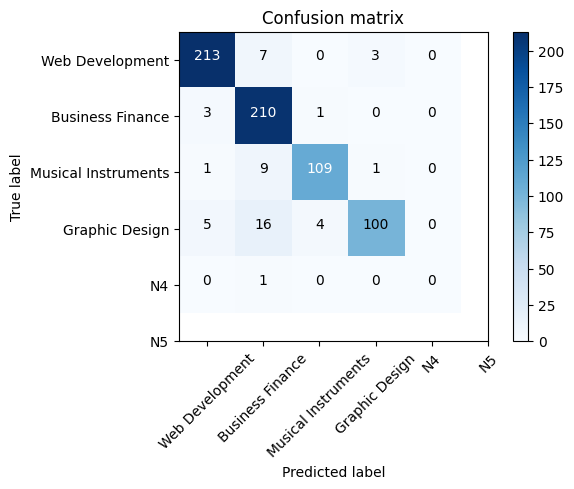

In [43]:
class_names = ['Web Development', 'Business Finance', 'Musical Instruments', 'Graphic Design','N4','N5']
plot_confusion_matrix(cm,class_names)

In [44]:
import warnings
warnings.filterwarnings('ignore')
# Classication Report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       223
         1.0       0.86      0.98      0.92       214
         2.0       0.96      0.91      0.93       120
         3.0       0.96      0.80      0.87       125
         5.0       0.00      0.00      0.00         1

    accuracy                           0.93       683
   macro avg       0.75      0.73      0.74       683
weighted avg       0.93      0.93      0.92       683



In [45]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_names

### Single prdiction

In [47]:
from pyspark.sql.types import StringType
ex1 = spark.createDataFrame([
    ("Building Machine Learning Apps with Python and PySpark",StringType())
],
# Column Name
["course_title", "label"]

)
ex1.show()

+--------------------+-----+
|        course_title|label|
+--------------------+-----+
|Building Machine ...|   {}|
+--------------------+-----+



In [48]:
# Predict
pred_ex1 = lr_model.transform(ex1)
pred_ex1.show()

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        course_title|label|            mytokens|     filtered_tokens|         rawFeatures|  vectorizedFeatures|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Building Machine ...|   {}|[building, machin...|[building, machin...|(3968,[56,81,117,...|(3968,[56,81,117,...|[16.1700882195045...|[0.99999970968396...|       0.0|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+



In [49]:
pred_ex1.select('course_title','rawPrediction','probability','prediction').show()

+--------------------+--------------------+--------------------+----------+
|        course_title|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|Building Machine ...|[16.1700882195045...|[0.99999970968396...|       0.0|
+--------------------+--------------------+--------------------+----------+

